---
title: "3D IP Inversion"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** induced polarization, 3D inversion, sparse norm, tree mesh.

</br>

**Summary:** Here we invert apparent chargeability data to recover the subsurface chargeability distribution on a tree mesh. We demonstrate two inversion approaches for recovering a chargeability model:

1. Weighted least-squares inversion
2. Iteratively re-weighted least-squares (IRLS) inversion

Almost all of the details of defining and carrying out weighted least-squares and iteratively weighted least squares inversion were covered in the [3D DC Resistivity Inversion](fwd_dcip_3d.ipynb) tutorial. And functionality specific to defining the IP forward simulation was covered in the [3D IP Forward Simulation](fwd_dcip_3d.ipynb) tutorial. As we will focus primarily on content specific to IP inversion, we strongly urge the reader to work through the aforementioned tutorials prior to working through this one.

</br>

**Learning Objectives:**

- Assigning appropriate uncertainties to IP data
- Designing a mesh for IP inversion
- Obtaining a background conductivity/resistivity model for the IP inversion
- Analyzing inversion results

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to IP is imported from [simpeg.electromagnetics.static.induced_polarization](xref:simpeg#simpeg.electromagnetics.static.induced_polarization).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    convert_survey_3d_to_2d_lines,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip_xyz
from simpeg.utils import download, model_builder, get_default_solver
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

try:
    import plotly
    from simpeg.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import tarfile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

mpl.rcParams.update({"font.size": 16})

## Load and Plot Tutorial Data

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/06-ip/inv_ip_3d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
data_filename = dir_path + "ip_data.xyz"

overwriting D:\Documents\Repositories\user-tutorials\notebooks\06-ip\inv_ip_3d_files.tar.gz
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\06-ip\inv_ip_3d_files.tar.gz
Download completed!


C:\Users\devin\AppData\Local\Temp\ipykernel_25408\1251919568.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


/tmp/ipykernel_978829/1251919568.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


### Load the Topography

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [3]:
topo_xyz = np.loadtxt(str(topo_filename))

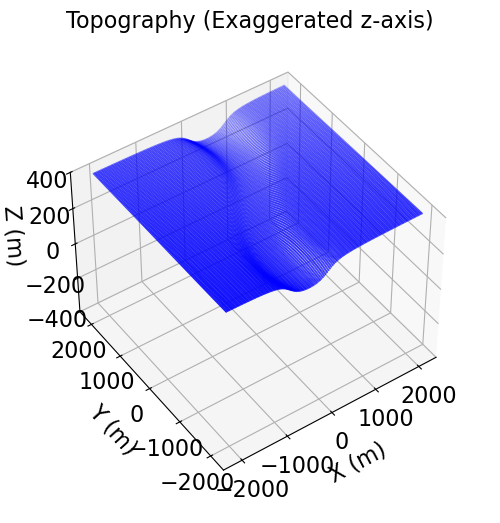

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

### Load IP Data

**Option A: DCIP3D formatted data**

The [read_dcip3d_ubc](xref:simpeg#simpeg.utils.io_utils.read_dcip3d_ubc) utility function can be used to load DC/IP data stored in a UBC-GIF formatted file. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object.

**Option B: Load XYZ formatted data**

For this tutorial, the observed data are organized within an XYZ formatted file. We can use the [read_dcip_xyz](xref:simpeg#simpeg.utils.io_utils.read_dcip_xyz) utility function to load data in this format. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object. The data are apparent chargeabilities in V/V.

The `dict_headers` input argument can be used to import other data columns that are not required to define the SimPEG data object. In this case, we import a column that defines the survey line associated with each datum. We will use this to plot pseudosections for individual survey lines.

In [5]:
ip_data, out_dict = read_dcip_xyz(
    data_filename,
    "apparent_chargeability",
    data_header="APP_CHG",
    uncertainties_header="UNCERT",
    is_surface_data=False,
    dict_headers=["LINEID"],
)

### Plot Observed Data in 3D Pseudosection

Here we use the [plot_3d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_3d_pseudosection) utility function to represent the observed data in pseudosection. In this case, the apparent chargeabilities are represented in V/V.

In the case of secondary voltage data, you would need to convert the values to apparent chargeabilities. This accomplished by normalizing the secondary IP voltages by the DC voltages.

In [6]:
if has_plotly:
    fig = plot_3d_pseudosection(
        ip_data.survey,
        ip_data.dobs,
        scale="linear",
        units="V/V",
        vlim=[0, np.max(ip_data.dobs)],
        marker_opts={"colorscale": "plasma"},
    )

    fig.update_layout(
        title_text="Apparent Chargeability",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot Observed Data in 2D Pseudosection

As demonstrated in the [3D Forward Simulation](fwd_dcr_3d.ipynb) tutorial, we can parse the 3D survey into a set of 2D survey lines if we know which survey line is associated with each datum. Then we can plot individual pseudosections for each survey line. We use the [convert_survey_3d_to_2d_lines](simpeg#simpeg.electromagnetics.static.utils.convert_survey_3d_to_2d_lines) to generate the list of 2D surveys. And we use the [plot_2d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_2d_pseudosection) utility function to plot the pseudosection for the desired survey line.

In [7]:
# Extract line IDs and make sure they are integers
lineID = np.array(out_dict["LINEID"], dtype=int)

In [8]:
# Create list of 2D surveys
survey_2d_list, index_list = convert_survey_3d_to_2d_lines(
    ip_data.survey, lineID, data_type="apparent_chargeability", output_indexing=True
)

In [9]:
dobs_2d_list = []
apparent_chargeabilities_2d = []
for ind in index_list:
    dobs_2d_list.append(ip_data.dobs[ind])
    apparent_chargeabilities_2d.append(ip_data.dobs[ind])

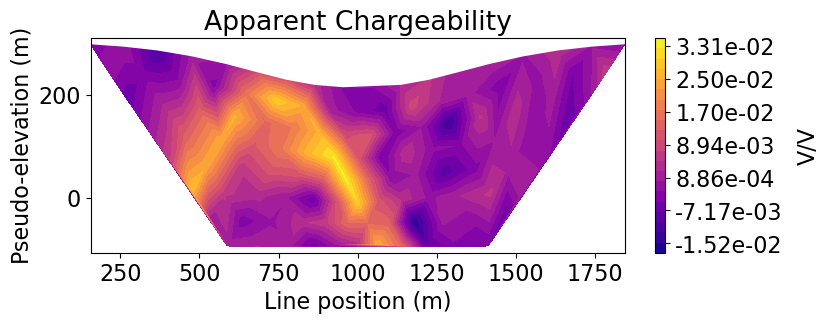

In [10]:
line_index = 0

fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey_2d_list[line_index],
    dobs=apparent_chargeabilities_2d[line_index],
    plot_type="contourf",
    ax=ax1,
    scale="linear",
    cbar_label="V/V",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.plasma},
)
ax1.set_title("Apparent Chargeability")
plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For secondary voltage data,** we generally apply a percent uncertainty and a very small floor uncertainty to all data. Differences in electrode spacing and subsurface conductivity result in secondary voltage IP data that span many orders of magnitude. A percent uncertainty ensures all data are fit equally. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages.

**For apparent chargeability data,** we generally apply a floor uncertainty to all data. This is because apparent chargeability data is obtained by normalizing the secondary voltage defining the IP signature by the DC voltage. This effectively removes the influence of electrode spacing on the amplitude of the datum. Here, we apply a floor uncertainty of 5e-3 V/V to all data.

In [11]:
ip_data.standard_deviation = 5e-3 * np.ones_like(ip_data.dobs)

## Design a (Tree) Mesh

IP inversion is carried out on the same mesh that is used for DC resistivity inversion. Here, we reproduce the survey-based meshing approach that was used in the  [3D Inversion of DC Resistivity Data](../05-dcr/inv_dcr_3d.ipynb) tutorial. The best-practices for meshes design for DC/IP problems is provided in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial. The same rules for defining appropriate meshes for 2.5D simulations and inversion apply to 3D simulations and inversion.

**Tutorial mesh:** Here, a minimum cell width of 25 m (or 1/4 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 1000 m, so a the padding was extended at least 3000 m from the survey region. Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](xref:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [12]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Extract unique electrode locations.
unique_locations = ip_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[8, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

## Define the Active Cells

Use the [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function to obtain the indices of the active mesh cells from topography (e.g. cells below surface).

In [13]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

## Project Electrodes to Discretized Topography

Surface IP data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to inverting surface IP data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [14]:
ip_data.survey.drape_electrodes_on_topography(
    mesh, active_cells, topo_cell_cutoff="top", shift_horizontal=True,
)

## Define the Background Conductivity/Resistivity

In order to invert IP data, we require the background conductivity/resistivity defined on the entire mesh. **In practice,** a conductivity/resistivity model is recovered via inverting DC resistivity data; see the [3D Inversion of DC Resistivity Data](../05-dcr/inv_dcr_3d.ipynb) tutorial. Since the conductivity/resistivity model greatly impacts the sensitivities for the IP problem, IP inversion is most successful when the recovered conductivity/resistivity model accurately characterizes the true subsurface distribution of electrical properties. **For the tutorial,** the true subsurface conductivity is used as the background conductivity for the IP inversion.

In [15]:
# Define conductivity model in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [16]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [17]:
# Define the mapping from the model to conductivity for all mesh cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [18]:
# Mapping to ignore inactive cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

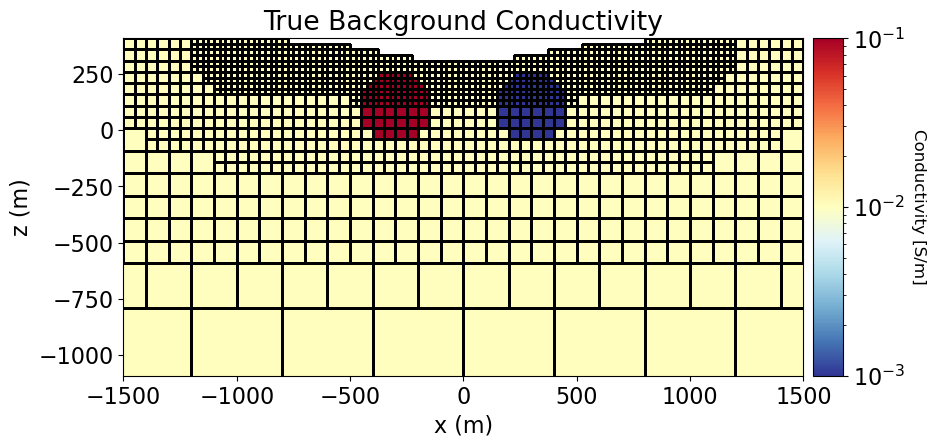

In [19]:
fig = plt.figure(figsize=(10, 4.5))

log_norm = LogNorm(vmin=1e-3, vmax=0.1)

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": log_norm},
)
ax1.set_title("True Background Conductivity")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([topo_xyz[:, -1].max() - 1500, topo_xyz[:, -1].max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.RdYlBu_r, norm=log_norm, orientation="vertical"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](xref:numpy#numpy.ndarray)) to the physical property values of all cells in the mesh. Mappings are created using the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module.

SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal). In this formulation, any standard definition of the chargeability can be inverted. And the units of the recovered chargeability values is the same as the data units; e.g. intrinsic chargeability (V/V or mV/V) or integrated chargeability (ms). If you are inverting secondary voltages however, the chargeability model must represent intrinsic chargeabilities ($0 \leq \eta \leq 1$) in V/V.

**In this tutorial,** the model parameters are the subsurface chargeabilities ($0 \leq \eta \leq 1$) in V/V. We use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) map to project the active cell chargeabilities to the entire mesh. 

In [20]:
# Model parameters to all cells
chargeability_map = maps.InjectActiveCells(mesh, active_cells, 0.0)

## Starting/Reference Model for IP Inversion

Here, we would create starting and/or reference models for the IP inversion as well as the mapping from the model space to the active cells. Starting and reference models can be a constant background value or contain a-priori structures. Here, the starting model is the 1e-6 V/V. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration.

In [21]:
# Create starting model from log-conductivity
starting_chargeability_model = 1e-4 * np.ones(n_active)

# Zero reference conductivity model
reference_chargeability_model = np.zeros_like(starting_chargeability_model)

## Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 3D IP was discussed in the [3D IP Forward Simulation](fwd_dcip_3d.ipynb) tutorial. Here, we use the [Simulation3DNodal](xref:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation3DNodal) simulation which solves for the electric potential on mesh nodes.

Since we are using a background *conductivity* model, we use ``sigma`` to define the background conductivity on the entire mesh. Because the IP problem has been linearized, we store the sensitivities for the inversion using ``storeJ``.

In [22]:
simulation_L2 = ip.Simulation3DNodal(
    mesh,
    survey=ip_data.survey,
    sigma=conductivity_map * conductivity_model,
    etaMap=chargeability_map,
    solver=get_default_solver(),
    storeJ=True,
)

## Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [23]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=ip_data)

## Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Length scales along x, y and z are used to balance the smallness and smoothness terms. And the reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros.

By default, the regularization acts on the model parameters; which in the case are the log-conductivities of the active cells. So we need to specify which cells are active in the regularization. And if we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [24]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    length_scale_x=10.0,
    length_scale_y=10.0,
    length_scale_z=10.0,
    reference_model=reference_chargeability_model,
    reference_model_in_smooth=False,
)

## Define the Optimization Algorithm

Here, we use the [ProjectedGNCG](xref:simpeg#simpeg.optimization.ProjectedGNCG) class to solve the optimization problem using projected Gauss-Newton with conjugate gradietn solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches. Here, the `lower` property is set to 0 to ensure recovered chargeability values are positive.

In [25]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=40, lower=0.0, maxIterLS=20, cg_maxiter=50, cg_rtol=1e-2
)

## Define the Inverse Problem

We use the [BaseInvProblem](xref:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [26]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are applied while the inversion is running. Here, we apply common directives for weighted least-squares inversion of IP data and describe their roles. These are:

- [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendency of IP inversion to place materials near the electrodes. Since the IP problem has been linearized, we do not need to update the sensitivities and we set `every_iteration=False`. For IP inversion, we do not want to use the entire dynamic range of the sensitivities to generate our weighting. So we generally set `threshold_value` to a value betwewen 1e-4 and 1e-1.

- [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=False` because the ideal preconditioner because the forward problem and regularization are not model-dependent.

- [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [27]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=False, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1000)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

## Define and Run the Inversion

We define the inversion using the [BaseInversion](xref:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [28]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_chargeability_L2 = inv_L2.run(starting_chargeability_model)


Running inversion with SimPEG v0.25.0


INFO: Directive TargetMisfit: Target data misfit is 696.0


================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  7.65e-01  1.67e+03  1.32e+01  1.68e+03                         0           inf          inf                
   1  7.65e-01  1.29e+03  1.99e+02  1.44e+03    2.62e+03      0      50       9.40e-03     9.71e+01              
   2  7.65e-01  1.29e+03  1.99e+02  1.44e+03    6.57e+02      0      38       9.47e-03     4.20e+00              
   3  3.83e-01  1.14e+03  4.73e+02  1.32e+03    1.11e+03      0      46       9.89e-03     1.26e+01              
   4  3.83e-01  1.14e+03  4.72e+02  1.32e+03    5.13e+02      0      33       9.76e-03     1.81e+00              
   5  1.91e-01  1.00e+03  9.97e+02  1.19e+03    8.89e+02      0      36       9.29e-03 

model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  7.91e-01  1.67e+03  1.32e+01  1.68e+03    2.87e+03      0              


   1  7.91e-01  1.28e+03  1.99e+02  1.44e+03    1.21e+03      0              


   2  3.96e-01  1.28e+03  1.88e+02  1.36e+03    1.24e+03      0              


   3  3.96e-01  1.13e+03  4.61e+02  1.31e+03    4.96e+02      0              


   4  1.98e-01  1.13e+03  4.57e+02  1.22e+03    9.33e+02      0              


   5  1.98e-01  9.92e+02  9.62e+02  1.18e+03    2.02e+02      0              


   6  9.89e-02  9.93e+02  9.59e+02  1.09e+03    7.42e+02      0              


   7  9.89e-02  8.76e+02  1.80e+03  1.05e+03    2.16e+02      0              


   8  4.94e-02  8.77e+02  1.80e+03  9.65e+02    5.97e+02      0              


   9  4.94e-02  7.84e+02  3.13e+03  9.39e+02    1.04e+02      0              


  10  2.47e-02  7.85e+02  3.12e+03  8.62e+02    4.71e+02      0              


  11  2.47e-02  7.13e+02  5.22e+03  8.42e+02    7.18e+01      0              


  12  1.24e-02  7.14e+02  5.18e+03  7.78e+02    3.74e+02      0              


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.6814e+02
0 : |xc-x_last| = 2.3741e-01 <= tolX*(1+|x0|) = 1.0267e-01
0 : |proj(x-g)-x|    = 3.7356e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.7356e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =     13
------------------------- DONE! -------------------------


## Analyze Inversion Outputs

### Plot Normalized Data Misfit in 3D Pseudosection

To see how well the recovered model reproduces the observed data, it is a good idea to compare the predicted and observed data.
Here, we plot the normalized data misfit to determine whether the observed data are fit evenly. Correlated signatures in the normalized data misfits indicate we are overfitting/underfitting certain data. And that we must modify our uncertainties and re-run the inversion.

In [29]:
# Predicted data from recovered model
dpred_ip = inv_prob_L2.dpred

# Compute the normalized data misfit
ip_normalized_misfit = (ip_data.dobs - dpred_ip) / ip_data.standard_deviation

if has_plotly:
    fig = plot_3d_pseudosection(
        ip_data.survey,
        ip_normalized_misfit,
        scale="linear",
        units="",
        vlim=[-2.5, 2.5],
        marker_opts={"colorscale": "RdYlBu"},
    )

    fig.update_layout(
        title_text="Normalized Data Misfit",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot 2D Pseudsections for Individual Survey Lines

For large datasets comprised of many survey lines, interpretation can be challenging if we plot every datum. Here, we plot the observed data, predicted data and data misfit for a specified survey line.

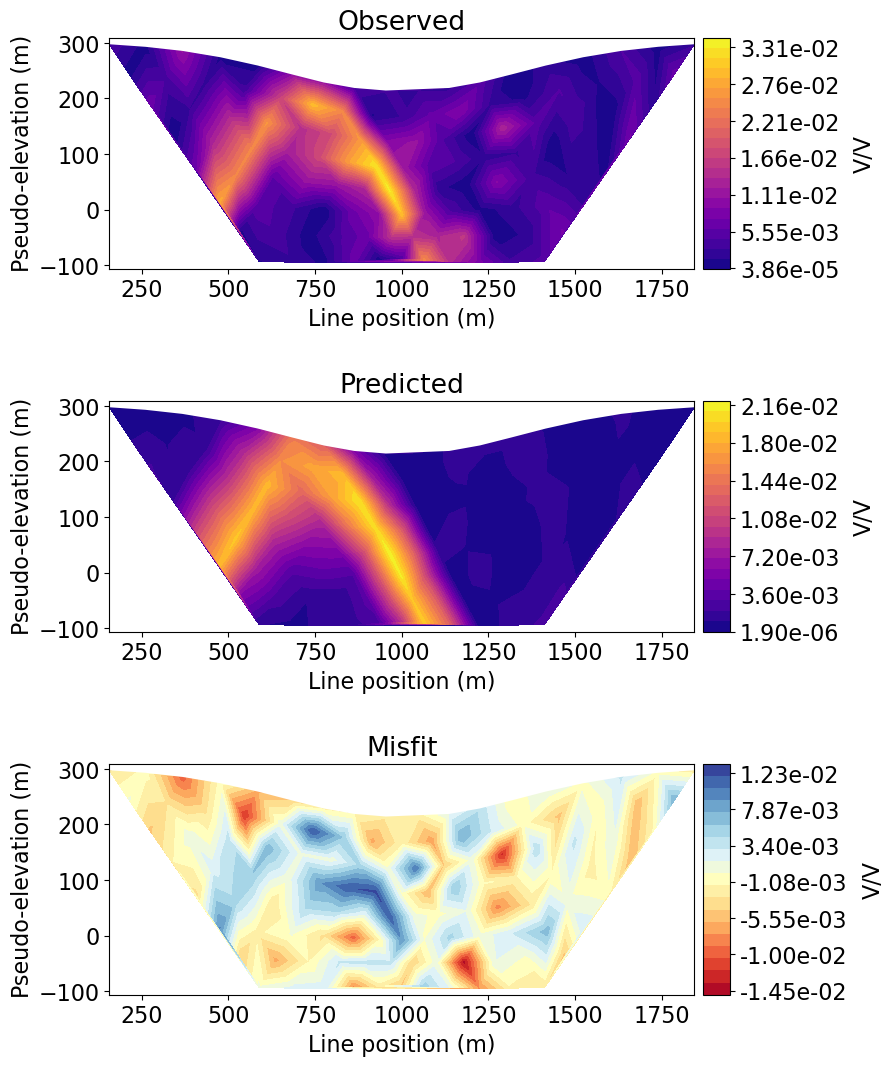

In [30]:
# Data associated with the line index provided
line_index = 0
k = lineID == line_index + 1
data_array = [
    np.abs(ip_data.dobs[k]),
    np.abs(dpred_ip[k]),
    ip_data.dobs[k] - dpred_ip[k],
]

# Plot 2D pseudosections (observed, predicted, normalized misfit)
fig = plt.figure(figsize=(9, 11))
plot_title = ["Observed", "Predicted", "Misfit"]
plot_units = ["V/V", "V/V", "V/V"]
scale = ["linear", "linear", "linear"]
cmap_list = [mpl.cm.plasma, mpl.cm.plasma, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        survey_2d_list[line_index],
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### Plot True and Recovered Chargeability Models

In [31]:
# Define intrinsic chargeability model (V/V)
air_value = 0.0
background_value = 1e-6
chargeable_value = 0.1

# Define true chargeability model
true_chargeability_model = background_value * np.ones(n_active)

ind_chargeable = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)

true_chargeability_model[ind_chargeable] = chargeable_value

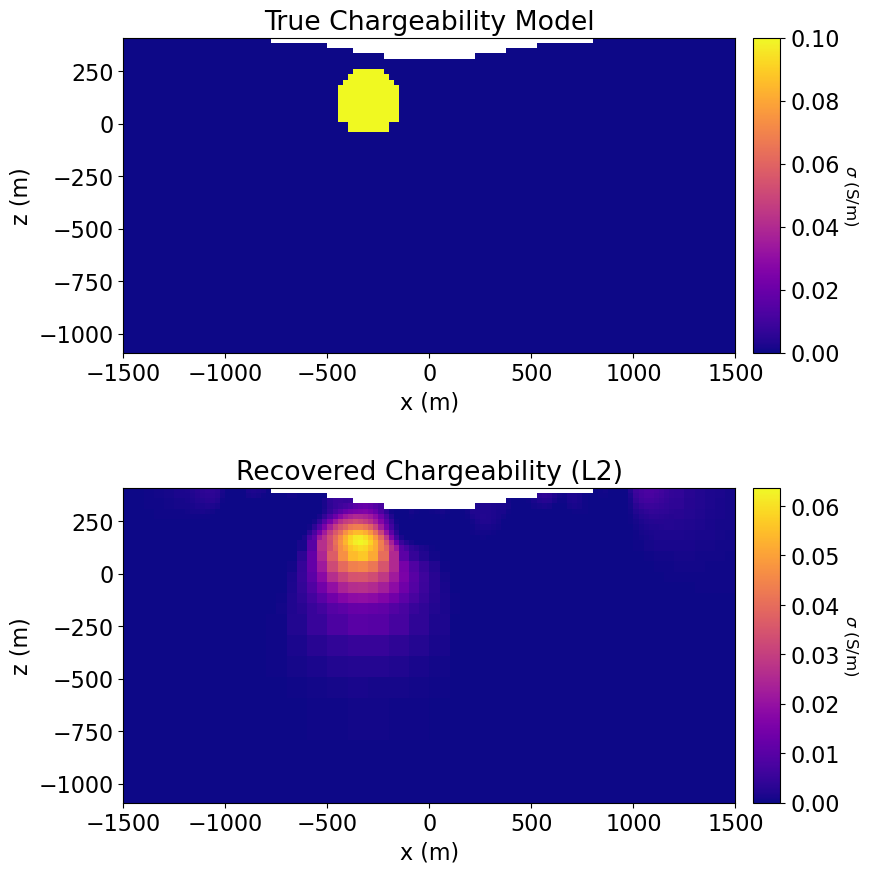

In [32]:
fig = plt.figure(figsize=(9, 9))
ax1 = 2 * [None]
ax2 = 2 * [None]
cbar = 2 * [None]
norm = 2 * [None]
title_str = [
    "True Chargeability Model",
    "Recovered Chargeability (L2)",
]

for ii, m in enumerate([true_chargeability_model, recovered_chargeability_L2]):
    norm[ii] = Normalize(vmin=0.0, vmax=np.max(m))

    ax1[ii] = fig.add_axes([0.14, 0.6 - 0.5 * ii, 0.68, 0.35])

    mesh.plot_slice(
        plotting_map * m,
        ax=ax1[ii],
        normal="Y",
        ind=int(len(mesh.h[1]) / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm[ii]},
    )
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")
    ax1[ii].set_xlim([-1500, 1500])
    ax1[ii].set_ylim([topo_xyz[:, -1].max() - 1500, topo_xyz[:, -1].max()])

    ax2[ii] = fig.add_axes([0.84, 0.6 - 0.5 * ii, 0.03, 0.35])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar[ii].set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)